# Deep Learning - Building a Deep Neural Network from scratch

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import glob
import sys

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [17]:
class NeuralNetwork(object):
    """
    Abstraction of neural network.
    Stores parameters, activations, cached values. 
    Provides necessary functions for training and prediction. 
    """
    def __init__(self, layer_dimensions, activation, optimization, drop_prob=0.0, reg_lambda=0.0):
        """
        Initializes the weights and biases for each layer
        layer_dimensions: (list) number of nodes in each layer
        activation: choice of activation functions ~ implemented relu, leaky relu, swish
        drop_prob: drop probability for dropout layers
        reg_lambda: regularization parameter
        """
        np.random.seed(1)
        
        self.parameters = {}
        self.num_layers = len(layer_dimensions)
        self.layer_dimensions = layer_dimensions
        self.drop_prob = drop_prob
        self.reg_lambda = reg_lambda
        self.activation = activation
        self.optimizer = optimization
        self.train_cost = []
        self.val_cost = []
        self.train_accuracy = []
        self.val_accuracy = []
        
        # init parameters        
        model = {}
        
        for i in range(len(layer_dimensions) - 1):
            layer_ahead = layer_dimensions[i+1]
            layer_behind = layer_dimensions[i]
            model['W'+str(i+1)] = np.random.randn(layer_ahead, layer_behind) * np.sqrt(2.0/(layer_ahead+layer_behind))
            model['b'+str(i+1)] = np.zeros((layer_ahead,1))
            
        self.parameters = model

    def affineForward(self, A, W, b):
        """
        Forward pass for the affine layer.
        A: input matrix, shape (L, S), where L is the number of hidden units in the previous layer and S is
        the number of samples
        W: Weight Matrix
        b: bias
        returns: the affine product WA + b, along with the cache required for the backward pass
        """
        samples = A.shape[1]
        features = A.shape[0]
        
        Z = np.dot(W,A) + b
        return Z

    def activationForward(self, A):
        """
        Common interface to access all activation functions.
        A: input to the activation function
        returns: activation(A)
        """ 
        if self.activation == "relu":
            A = self.relu(A)
        elif self.activation == "lrelu":
            A = self.leaky_relu(A,0.1)
        elif self.activation == "swish":
            A = self.swish(A)
        return A


    def relu(self, X):
        """ReLU activation unit as proposed in the Krizhevsky et al. 2012"""
        activation = np.maximum(0,X)
        return activation
    
    def leaky_relu(self, X, alpha):
        """Leaky ReLU activation unit.
           alpha: the hyperparameter that replaces 0 in the ReLU"""
        x = X.copy()
        out = self.relu(x) - alpha * self.relu(-x)
        return out
        
    def swish(self, X):
        """Swish activation unit as proposed by Ramachandran et al
           https://arxiv.org/pdf/1710.05941.pdf"""
        
        x = X.copy()
        out = x * self.sigmoid(x)
        return out
        
    def sigmoid(self, X):
        """Sigmoid activation unit"""
        x = X.copy()
        out = 1/(1 + np.exp(-x))
        return out
            
    def softmax(self, X):
        """Numerically Stable Softmax activation for the last layer of the Neural Network"""
        S = X - np.amax(X, axis=0)
        S = np.exp(S)
        total = np.sum(S,axis=0, keepdims=True)
        soft_m = S/total
        
        return soft_m
    
    def dropout(self, A, prob):
        """
        A: Activation
        prob: dropout prob
        returns: tuple (A, M) 
            WHERE
            A is matrix after applying dropout
            M is dropout mask, used in the backward pass
        """
        M = np.random.rand(A.shape[0], A.shape[1])
        M = (M >= prob)*1.0
        M /= (1- prob)
        A *= M
        return A, M

    def forwardPropagation(self, X):
        """
        Runs an input X through the neural network to compute activations
        for all layers. Returns the output computed at the last layer along
        with the cache required for backpropagation.
        :returns: (tuple) AL, cache
            WHERE 
            AL is activation of last layer
            cache is cached values for each layer that
                     are needed in further steps
        """
        cache = {} #Dictionary Data Structure used to store the relevant values that will be used in further computations
        cache['A' + str(0)] = X
        ls = self.num_layers
        
        for i in range(ls - 2):
            W = self.parameters['W' + str(i+1)]
            b = self.parameters['b' + str(i+1)]
            A = cache['A' + str(i)]
            Z = self.affineForward(A, W, b)
            A_next = self.activationForward(Z)
            
            if self.drop_prob > 0:
                A_next, M = self.dropout(A_next, self.drop_prob)
                cache['M' + str(i+1)] = M
            
            cache['A'+str(i+1)] = A_next
            cache['Z'+str(i+1)] = Z
        
        W = self.parameters['W'+str(ls-1)]
        b = self.parameters['b'+str(ls-1)]
        A_class = cache['A'+str(ls-2)]
        
        AL = self.affineForward(A_class, W, b) #without softmax. softmax will be applied while calculating the cost function
        
        return AL, cache
    
    def costFunction(self, AL, y):
        """
        AL: Activation of last layer, shape (num_classes, S)
        y: labels, shape (S)
        returns cost, dAL: A scalar denoting cost and the gradient of cost
        """
        # compute loss
        AL = self.softmax(AL)
        
        true_labels = one_hot(y)

        y_hat = AL[y, range(y.shape[0])]
        #y_hat[y_hat == 0] = 10**-10
        #Computing the cross entropy loss
        cost = -np.sum(np.log(y_hat))/ AL.shape[1] 
        
        if self.reg_lambda > 0:
            # add regularization
            reg_loss = 0
            for i in range(1, self.num_layers):
                reg_loss += (0.5 * self.reg_lambda * np.sum(self.parameters["W"+str(i)] * self.parameters["W"+str(i)]))
            cost += reg_loss
                
            #W_1, W_2, W_3 = self.parameters['W1'], self.parameters['W2'], self.parameters['W3']
            #reg_loss = (0.5 * self.reg_lambda * np.sum(W_1*W_1)) + (0.5 * self.reg_lambda * np.sum(W_2*W_2)) + (0.5 * self.reg_lambda * np.sum(W_3*W_3))
            #cost = cost + reg_loss
         
        dAL = AL - true_labels
        return cost, dAL

    def affineBackward(self, dA_prev, cache, layer):
        """
        Backward pass for the affine layer.
        dA_prev: gradient from the next layer.
        cache: cache returned in affineForward
        returns dA: gradient on the input to this layer
                dW: gradient on the weights
                db: gradient on the bias
        """
        A = cache['A'+str(layer-1)]
        W = self.parameters['W'+str(layer)]
        samples = dA_prev.shape[1]
        
        if self.drop_prob > 0:
            dA_prev = self.dropout_backward(dA_prev, cache, layer)
        
        dZ = self.activationBackward(dA_prev, cache, layer, "lrelu")
        dW = 1/samples * np.dot(dZ, A.T)
        db = 1/samples * np.sum(dZ, axis = 1, keepdims = True)
        dA = np.dot(W.T, dZ)
        
        return dA, dW, db

    def activationBackward(self, dA, cache, layer, activation):
        """
        Interface to call backward on activation functions.
        In this case, it's just relu. 
        """
        Z = cache['Z'+str(layer)]
        if activation == "relu":
            dx = self.relu_derivative(dA, Z)
        elif activation == "lrelu":
            dx = self.lrelu_derivative(dA, Z, 0.1)
        elif activation == "swish":
            dx = self.swish_derivative(dA, Z)
        return dx
    
    def relu_derivative(self, dx, cached_x):
        """Derivative of ReLU activation used during Backpropagation"""
        dA = dx * 1 * (cached_x > 0)
        return dA

    def lrelu_derivative(self, dx, cached_x, alpha):
        """Derivative of Leaky ReLU activation used during Backpropagation"""
        dA = np.ones_like(cached_x)
        dA[cached_x < 0] = alpha
        return dA*dx
    
    def swish_derivative(self, dx, cached_x, beta):
        """Derivative of Swish activation used during Backpropagation"""
        sig = self.sigmoid(dx)
        return sig + (dx*sig*(1-sig))
    
    def dropout_backward(self, dA, cache, layer):
        """Derivative of Dropout used during Backpropagation"""
        m= cache['M' + str(layer)]
        return np.multiply(m, dA) / (1 - self.drop_prob)

    def backPropagation(self, dAL, AL, cache):
        """
        Run backpropagation to compute gradients on all paramters in the model
        dAL: gradient on the last layer of the network. Returned by the cost function.
        Y: labels
        cache: cached values during forwardprop
        returns gradients: dW and db for each weight/bias
        """
        gradients = {}
        

        samples = AL.shape[1]
        features = AL.shape[0]
        layers = self.num_layers
        
        #computing gradients using error at the output, bias at the output, and the weight matrix immediately before
        A = cache['A' + str(layers - 2)] # Activations at the layer previous layer
        W = self.parameters['W' + str(layers - 1)]
        dZ = dAL
        dW = 1/samples * np.dot(dZ, A.T)
        db = 1/samples * np.sum(dZ, axis = 1, keepdims = True)
        dA = np.dot(W.T, dZ)
        
        gradients['dW' + str(self.num_layers - 1)] = dW
        gradients['db' + str(self.num_layers - 1)] = db
        
        
        for layer in range(layers-2,0,-1):
            dA, dW, db = self.affineBackward(dA, cache, layer)
            gradients['dW' + str(layer)] = dW
            gradients['db' + str(layer)] = db
            
            
           
        if self.reg_lambda > 0:
            # add gradients from L2 regularization to each dW
            for i in range(self.num_layers - 2):
                dW = gradients['dW' + str(i + 1)]
                W = self.parameters['W' + str(i + 1)]
                dW_updated = dW + self.reg_lambda /samples * W
                gradients['dW' + str(i + 1)] = dW_updated
        
        return gradients


    def updateParameters(self, gradients, alpha, iteration, Optim_Dict):
        """
        Updates the parameters according to the Optimization algorithm specified
        gradients: gradients for each weight/bias
        alpha: step size for gradient descent 
        """
        if self.optimizer == "Adam":
            #Hyperparameters for Adam Optimization ~ beta1 and beta2 corresponds to the decay rates and eps ensure division is not by zero
            beta1, beta2, eps = 0.9, 0.999, 1e-8

            for l in range(1, self.num_layers):
                Optim_Dict["Vdw"+str(l)] = (beta1 * Optim_Dict["Vdw"+str(l)]) + ((1 - beta1) * gradients["dW" + str(l)])
                Optim_Dict["Vdb"+str(l)] = (beta1 * Optim_Dict["Vdb"+str(l)]) + ((1 - beta1) * gradients["db" + str(l)])
                Optim_Dict["Sdw"+str(l)] = (beta2 * Optim_Dict["Sdw"+str(l)]) + ((1 - beta2) * (gradients["dW" + str(l)] * gradients["dW" + str(l)]))
                Optim_Dict["Sdb"+str(l)] = (beta2 * Optim_Dict["Sdb"+str(l)]) + ((1 - beta2) * (gradients["db" + str(l)] * gradients["db" + str(l)]))

                Vdw_corr = (Optim_Dict["Vdw"+str(l)])/(1 - (beta1**(iteration+1)))
                Vdb_corr = (Optim_Dict["Vdb"+str(l)])/(1 - (beta1**(iteration+1)))
                Sdw_corr = (Optim_Dict["Sdw"+str(l)])/(1 - (beta2**(iteration+1)))
                Sdb_corr = (Optim_Dict["Sdb"+str(l)])/(1 - (beta2**(iteration+1)))

                self.parameters["W" + str(l)] = self.parameters["W" + str(l)] - alpha * (Vdw_corr/(np.sqrt(Sdw_corr) + eps))
                self.parameters["b" + str(l)] = self.parameters["b" + str(l)] - alpha * (Vdb_corr/(np.sqrt(Sdb_corr) + eps))

        elif self.optimizer == "SGD":
            for l in range(1, self.num_layers):
                self.parameters["W" + str(l)] = self.parameters["W" + str(l)] - alpha * gradients["dW" + str(l)]
                self.parameters["b" + str(l)] = self.parameters["b" + str(l)] - alpha * gradients["db" + str(l)]
        
    def train(self, X, y, iters=1000, alpha=0.001, batch_size=100, print_every=100):
        """
        X: input samples, each column is a sample
        y: labels for input samples, y.shape[0] must equal X.shape[1]
        iters: number of training iterations
        alpha: step size for gradient descent
        batch_size: number of samples in a minibatch
        print_every: no. of iterations to print debug info after
        """
        validation_size = int(X.shape[1]*.1)
        total_size = X.shape[1]
        validation_X = X[:,total_size - validation_size:]
        validation_y = y[total_size - validation_size:]
        
        X = X[:,0:total_size - validation_size]
        y = y[0:total_size - validation_size]
        
        shapes = []
        for j in range(len(self.layer_dimensions) - 1):
            shapes.append((self.layer_dimensions[j], self.layer_dimensions[j+1]))
        
        #initializing momentum and ubiases for advanced optimization techniques
        Optim_Dict = {}
        if self.optimizer != "SGD":
            for l in range(0, len(shapes)):
                layer_ahead = shapes[l][1]
                layer_behind = shapes[l][0]

                Optim_Dict["Vdw" + str(l+1)] = np.zeros((layer_ahead, layer_behind))
                Optim_Dict["Vdb" + str(l+1)] = np.zeros((layer_ahead, 1))
                Optim_Dict["Sdw" + str(l+1)] = np.zeros((layer_ahead, layer_behind))
                Optim_Dict["Sdb" + str(l+1)] = np.zeros((layer_ahead, 1))
        
        for i in range(0, iters):
            # get minibatch
            X_batch, y_batch = self.get_batch(X, y, batch_size)
            
            # forward prop
            AL, cache = self.forwardPropagation(X_batch)
            
            # compute loss
            cost, dAL = self.costFunction(AL, y_batch)

            # compute gradients
            gradients = self.backPropagation(dAL, AL, cache)

            # update weights and biases based on gradient
            self.updateParameters(gradients, alpha, i, Optim_Dict)
            
            if i % print_every == 0:
                t_pred = np.argmax(AL, axis=0)
                train_pred = np.mean(t_pred == y_batch)*100
                self.train_accuracy.append(train_pred)
                self.train_cost.append(cost)
                print("Training Set Accuracy after,",i,"iteration = ", round(train_pred,2),"%") 
                print("Training Set Cost after,",i,"iteration = ",round(cost,3))
                
                v_pred = self.predict(validation_X)
                val_pred = np.mean(v_pred == validation_y)*100
                self.val_accuracy.append(val_pred)
                print("Validation Set Accuracy after,",i,"iteration = ", round(val_pred,2), "%")
                print()

                
                
    def predict(self, X):
        """
        Make predictions for each sample
        """
        AL, _ = self.forwardPropagation(X)
        y_pred = np.argmax(AL, axis=0)
        
        return y_pred

    def get_batch(self, X, y, batch_size):
        """
        Return minibatch of samples and labels
        
        X, y: samples and corresponding labels
        batch_size: minibatch size
        returns: (tuple) X_batch, y_batch
        """
        idx = np.random.choice(X.shape[1], batch_size, replace=True)
        X_batch = X[:,idx]
        y_batch = y[idx]

        return X_batch, y_batch

In [16]:
# Helper Functions

def get_img_array(path):
    """
    Given path of image, returns it's numpy array
    """
    return scipy.misc.imread(path)

def get_files(folder):
    """
    Given path to folder, returns list of files in it
    """
    filenames = [file for file in glob.glob(folder+'*/*')]
    filenames.sort()
    return filenames

def get_label(filepath, label2id):
    """
    Files are assumed to be labeled as: /path/to/file/999_frog.png
    Returns label for a filepath
    """
    tokens = filepath.split('/')
    label = tokens[-1].split('_')[1][:-4]
    if label in label2id:
        return label2id[label]
    else:
        sys.exit("Invalid label: " + label)

In [4]:
# Functions to load data

def get_labels(folder, label2id):
    """
    Returns vector of labels extracted from filenames of all files in folder
    folder: path to data folder
    label2id: mapping of text labels to numeric ids. (Eg: automobile -> 0)
    """
    files = get_files(folder)
    y = []
    for f in files:
        y.append(get_label(f,label2id))
    return np.array(y)

def one_hot(y, num_classes=10):
    """
    Converts each label index in y to vector with one_hot encoding
    One-hot encoding converts categorical labels to binary values
    """
    y_one_hot = np.zeros((num_classes, y.shape[0]))
    y_one_hot[y, range(y.shape[0])] = 1

    return y_one_hot

def get_label_mapping(label_file):
    """
    Returns mappings of label to index and index to label
    The input file has list of labels, each on a separate line.
    """
    with open(label_file, 'r') as f:
        id2label = f.readlines()
        id2label = [l.strip() for l in id2label]
    label2id = {}
    count = 0
    for label in id2label:
        label2id[label] = count
        count += 1
    return id2label, label2id

def get_images(folder):
    """
    returns numpy array of all samples in folder
    each column is a sample resized to 30x30 and flattened
    """
    files = get_files(folder)
    images = []
    count = 0
    
    for f in files:
        count += 1
        if count % 10000 == 0:
            print("Loaded {}/{}".format(count,len(files)))
        img_arr = get_img_array(f)
        img_arr = img_arr.flatten() / 255.0
        images.append(img_arr)
    X = np.column_stack(images)

    return X

def get_train_data(data_root_path):
    """
    Return X and y
    """
    train_data_path = data_root_path + 'train'
    id2label, label2id = get_label_mapping(data_root_path+'labels.txt')
    print(label2id)
    X = get_images(train_data_path)
    y = get_labels(train_data_path, label2id)
    return X, y

def save_predictions(filename, y):
    """
    Dumps y into .npy file
    """
    np.save(filename, y)

In [6]:
# Load the data
data_root_path = 'cifar10/' #Specify the directory in which the data is stored
X_train, y_train = get_train_data(data_root_path) # this may take a few minutes
X_test = get_images(data_root_path + 'test')
print('Data loading done')

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Loaded 10000/50000
Loaded 20000/50000
Loaded 30000/50000
Loaded 40000/50000
Loaded 50000/50000
Loaded 10000/10000
Data loading done


## Simple Fully-Connected Deep Neural Network


In [19]:
layer_dimensions = [X_train.shape[0], 900, 600, 10]  # including the input and output layers
#In the function call below, specify the activation (relu, lrelu, or swish) and optimization algorithm (Adam or SGD)
NN = NeuralNetwork(layer_dimensions, 'lrelu', 'SGD')
#In the function call below, specify the hyperparameters
NN.train(X_train, y_train, iters=20000, alpha=0.03, batch_size=128, print_every=100)


Training Set Accuracy after, 0 iteration =  9.38 %
Training Set Cost after, 0 iteration =  2.409
Validation Set Accuracy after, 0 iteration =  10.58 %

Training Set Accuracy after, 100 iteration =  29.69 %
Training Set Cost after, 100 iteration =  1.992
Validation Set Accuracy after, 100 iteration =  32.44 %

Training Set Accuracy after, 200 iteration =  28.91 %
Training Set Cost after, 200 iteration =  1.902
Validation Set Accuracy after, 200 iteration =  34.66 %

Training Set Accuracy after, 300 iteration =  30.47 %
Training Set Cost after, 300 iteration =  1.861
Validation Set Accuracy after, 300 iteration =  31.52 %

Training Set Accuracy after, 400 iteration =  30.47 %
Training Set Cost after, 400 iteration =  1.952
Validation Set Accuracy after, 400 iteration =  36.92 %

Training Set Accuracy after, 500 iteration =  41.41 %
Training Set Cost after, 500 iteration =  1.656
Validation Set Accuracy after, 500 iteration =  39.36 %

Training Set Accuracy after, 600 iteration =  39.84 %

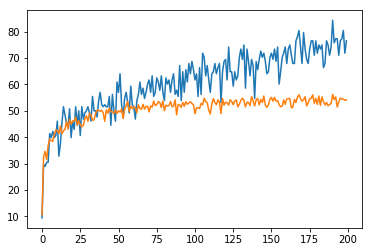

In [26]:
plt.plot(NN.train_accuracy,label = "Training Accuracy")
plt.plot(NN.val_accuracy, label = "Validation Accuracy")

In [27]:
y_predicted = NN.predict(X_test)
print(y_predicted)
save_predictions('ans1-uni', y_predicted)

[3 8 0 ... 2 4 4]


In [28]:
# test if your numpy file has been saved correctly
loaded_y = np.load('ans1-uni.npy')
print(loaded_y.shape)
loaded_y[:10]

(10000,)


array([3, 8, 0, 4, 5, 2, 8, 4, 8, 1])

## Regularized Neural Network with Dropout and L2

In [29]:
NN2 = NeuralNetwork(layer_dimensions, 'lrelu', 'SGD',drop_prob=0.2, reg_lambda=0.05)
NN2.train(X_train, y_train, iters=20000, alpha=0.03, batch_size=128, print_every=100)

Training Set Accuracy after, 0 iteration =  9.38 %
Training Set Cost after, 0 iteration =  55.768
Validation Set Accuracy after, 0 iteration =  10.6 %

Training Set Accuracy after, 100 iteration =  28.91 %
Training Set Cost after, 100 iteration =  55.17
Validation Set Accuracy after, 100 iteration =  28.94 %

Training Set Accuracy after, 200 iteration =  29.69 %
Training Set Cost after, 200 iteration =  55.027
Validation Set Accuracy after, 200 iteration =  32.46 %

Training Set Accuracy after, 300 iteration =  37.5 %
Training Set Cost after, 300 iteration =  54.833
Validation Set Accuracy after, 300 iteration =  34.8 %

Training Set Accuracy after, 400 iteration =  35.16 %
Training Set Cost after, 400 iteration =  54.944
Validation Set Accuracy after, 400 iteration =  33.74 %

Training Set Accuracy after, 500 iteration =  45.31 %
Training Set Cost after, 500 iteration =  54.587
Validation Set Accuracy after, 500 iteration =  37.38 %

Training Set Accuracy after, 600 iteration =  37.5 

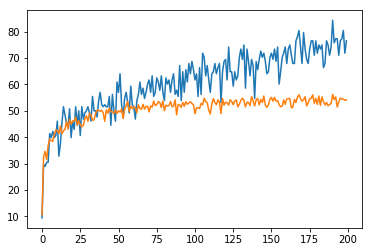

In [30]:
plt.plot(NN.train_accuracy,label = "Training Accuracy")
plt.plot(NN.val_accuracy, label = "Validation Accuracy")

In [31]:
y_predicted2 = NN2.predict(X_test)
save_predictions('ans2-uni', y_predicted2)
print(y_predicted2)

[3 8 8 ... 5 5 4]
